In [15]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import subprocess
import scipy as sc
from itertools import product

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.figsize": (4, 3.5),
    "text.latex.preamble": "\n".join([
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[T1]{fontenc}",
        r"\usepackage[detect-all,locale=FR]{siunitx}",
    ]),
    'lines.markersize': 10,
    'lines.color': 'grey',
    'scatter.marker': '+',
    'errorbar.capsize': 3,
    'savefig.bbox': 'tight',
})

In [16]:
path = '../'
executable = 'bin/ex2'
export_path = path + 'rapport/figures/'
data_path = 'data/'
config_path = 'bin/'
config_name = 'no_excitation'
config_ext = '.conf'

In [17]:
def stringify_dict(d: dict, sep=',') -> str:
    return sep.join(map(lambda a: str(a[0]) + "=" + str(a[1]), tuple(d.items())))

In [18]:
def run(config_file: str, output_file: str, params: dict = {}) -> None:
    # print(f"Running with config file {config_file}")
    options = stringify_dict(params, sep=' ')
    cmd = f"{path}{executable} {path}{config_file} output='{path}{output_file}' {options}"
    print(f"Running command `{cmd}`")
    subprocess.run(cmd, shell=True, stdout=subprocess.DEVNULL)
    # print("Done")

In [19]:
# nsteps = np.array([*range(500, 2001, 100)])
nsteps = np.array([2000])
nsimul = len(nsteps)  # Number of simulations to perform

conf = {}
with open(path + config_path + config_name + config_ext, 'r') as f:
    lines = f.read().split('\n')

for line in lines:
    if not line:
        continue
    name, _, val, *_ = line.split(' ')
    name = name.strip()
    val = val.strip()
    try:
        conf[name] = float(val)
    except ValueError:
        conf[name] = val

# 3 perides
omega0 = np.sqrt(conf['L']/conf['g'])
tFin = 6 * np.pi / omega0
dt = conf['tFin'] / nsteps

In [20]:
def analytical_theta(t: float) -> float:
    return conf['theta0'] * np.cos(omega0 * t)

In [21]:
def analytical_thetadot(t: float) -> float:
    return -omega0 * conf['theta0'] * np.sin(omega0 * t)

In [22]:
%%bash
cd .. && make clean && make

clang++ -o bin/ex2 src/Ex2_2024_student.cpp -std=c++17 -Wall -Wextra -O2 


In [23]:
params_variations = {
    'nsteps': nsteps,
    'theta0': np.linspace(0.1, np.pi - 0.1, 30),
}
all_params = tuple(
    {a: b for a, b in zip(params_variations.keys(), c)} for c in product(*params_variations.values())
)

# Run simulations
outputs = []  # List to store output file names
for params in all_params:
    output_file = f"{data_path}{config_name},{stringify_dict(params)}.out"
    outputs.append(output_file)
    run(f'{config_path}{config_name}{config_ext}', output_file, params)

Running command `../bin/ex2 ../bin/no_excitation.conf output='../data/no_excitation,nsteps=2000,theta0=0.1.out' nsteps=2000 theta0=0.1`
Running command `../bin/ex2 ../bin/no_excitation.conf output='../data/no_excitation,nsteps=2000,theta0=0.2014342294341308.out' nsteps=2000 theta0=0.2014342294341308`
Running command `../bin/ex2 ../bin/no_excitation.conf output='../data/no_excitation,nsteps=2000,theta0=0.3028684588682616.out' nsteps=2000 theta0=0.3028684588682616`
Running command `../bin/ex2 ../bin/no_excitation.conf output='../data/no_excitation,nsteps=2000,theta0=0.40430268830239235.out' nsteps=2000 theta0=0.40430268830239235`
Running command `../bin/ex2 ../bin/no_excitation.conf output='../data/no_excitation,nsteps=2000,theta0=0.5057369177365232.out' nsteps=2000 theta0=0.5057369177365232`
Running command `../bin/ex2 ../bin/no_excitation.conf output='../data/no_excitation,nsteps=2000,theta0=0.6071711471706539.out' nsteps=2000 theta0=0.6071711471706539`
Running command `../bin/ex2 ../b

In [24]:
# Filter stuff
file_and_params = []
all_data = {}

for file, params in zip(outputs, all_params):
    file_and_params.append((file, params))
    data = np.loadtxt(path + file)
    all_data[file] = (params, np.copy(data))

# Plots!

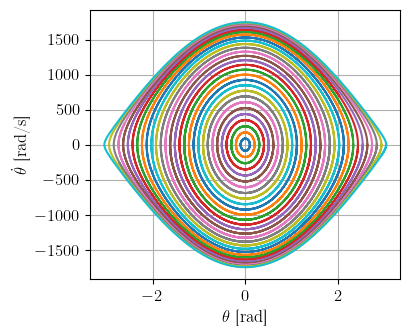

In [25]:
for (params, data) in all_data.values():
    t, theta, thetadot = data[:,0], data[:,1], data[:,2]
    # p = m L^2 thetadot
    plt.plot(theta, thetadot / (2 * conf['m'] * conf['L']**2))

# plt.axis('equal')
plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$\dot{\theta}$ [rad/s]')
plt.grid()
# plt.legend()
plt.savefig(export_path + 'feuriste.pdf')

In [30]:
periods = np.zeros(len(all_params))

for i, (params, data) in enumerate(all_data.values()):
    t, theta, thetadot = data[:,0], data[:,1], data[:,2]
    # Index of where thetadot change sign
    changes = np.where(thetadot[:-1] * thetadot[1:] < 0 )[0] +1
    total_periods = len(changes)
    total_time = t[changes[1]] - t[changes[0]]
    periods[i] = 1 / total_time

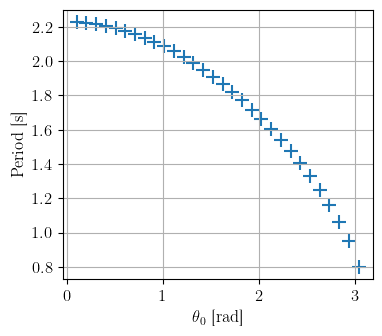

In [31]:
plt.scatter(params_variations['theta0'], periods)
plt.xlabel(r'$\theta_0$ [rad]')
plt.ylabel(r'Period [s]')
plt.grid()

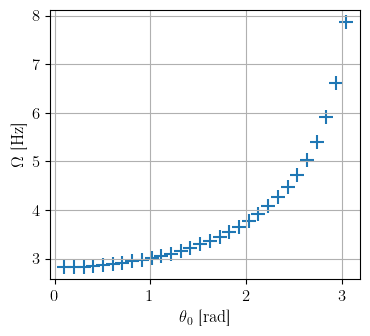

In [32]:
plt.scatter(params_variations['theta0'], 2*np.pi/periods)
plt.xlabel(r'$\theta_0$ [rad]')
plt.ylabel(r'$\Omega$ [Hz]')
plt.grid()